
**Initial the package and googledrive**

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

%cd /content/gdrive/My\ Drive/Colab\ Notebooks
!pwd

#poyglot package
!pip install PyICU
!pip install pycld2
!pip install morfessor
!pip install polyglot

#download package for word embedding
!polyglot download sgns2.en
!polyglot download sgns2.th
!polyglot download sgns2.ja

!pip install tika

#install additional fonts
!apt-get update
!apt-get install fonts-thai-tlwg  #Thai fonts
!apt-get install fonts-takao-mincho  #Japanese fonts


#== (2) Language Detection ==

In [0]:
print("\n== (2) Language Detection ==\n")
#word2vec and langualge detection
import polyglot
from polyglot.text import Text, Word, WordList

#reading the PDF file
import tika
from tika import parser
tika.initVM()

#read the system files
from os import listdir
from os.path import isfile, join

#Traget directory
TeagetDir = './files/documents/'

#List of all files in directory
allFiles = [f for f in listdir(TeagetDir) if isfile(join(TeagetDir, f))]

langDetectResult = []
content = []
i=0
#loop for all files 
for file in allFiles:
  print(f'\nLanguage detection:{file} [{i+1} of {len(allFiles)}]')

  #read PDF file content
  raw = parser.from_file(f'./files/documents/{file}')
  text = Text(raw['content'])

  #detect Language
  print(f'Detect language: {text.language.name}\n')
  content.append(raw['content']) # add raw content into list
  langDetectResult.append(text.language.code) # save the language detection result
  i+=1



#== (3) Text processing ==

In [0]:
print("\n== (3) Text processing ==\n")

import re
import sys
from string import punctuation

#for reading stopwords_iso
import json

#Stopwords-ISO from: https://github.com/stopwords-iso/stopwords-iso
stopwordsISOFilename = './files/stopwords-iso.json'
with open(stopwordsISOFilename, 'r') as f:
  stopwordsISO = json.load(f)

# (information from https://blog.ekbana.com/pre-processing-text-in-python-ad13ea544dae)

for i in range(len(content)):
 
  print(f'\nText processing: {allFiles[i]} [{i+1} of {len(allFiles)}]')
  print(f'original size:\t{sys.getsizeof(content[i])} [byte]')

  #save to temporary variable
  strContent = content[i]

  #remove Tags
  strContent = re.sub('<[^<]+?>','', strContent)

  #remove url links
  strContent = re.sub(r'^https?:\/\/.*[\r\n]*', '', strContent, flags=re.MULTILINE)

  #remove Number
  strContent = ''.join(c for c in strContent if not c.isdigit())

  #remove punctuation
  strContent =  ''.join(c for c in strContent if c not in punctuation)


  #to lowercase (english)
  if langDetectResult[i] == 'en':
    strContent = strContent.lower()

  #tokenization
  wordsContent = Text(strContent).words

  #removing stop words
  stopword = stopwordsISO[langDetectResult[i]] # select the stopword language
  wordsContent = [word for word in wordsContent if word not in stopword]

  content[i] = wordsContent
  print(f'reduse size:\t{sys.getsizeof(content[i])} [byte]')



#== (4) Cluster documents into logical groups  ==

In [0]:
print("\n== (4) Cluster documents into logical groups  ==\n")
from polyglot.text import Text, Word, WordList
import numpy as np


# ---- calculate document vector by using Word Vector Averaging ----
vectorResult = []
for fileNum in range(len(content)):
  print(f'Calculate average vector of: {allFiles[fileNum]} [{fileNum+1} of {len(allFiles)}]')
  tmpVector = []
  wl = WordList(content[fileNum],language =langDetectResult[fileNum])
  for wordNum in range(len(wl)):
    try:
      tmpVector.append(wl[wordNum].vector)
    except:
      pass
  avrVec = np.average(tmpVector, axis=0)
  vectorResult.append(avrVec)
vectorResult = np.array(vectorResult)


# ---- Cluster the document using Affinity propagation ----
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
from sklearn import preprocessing

#X = preprocessing.normalize(vectorResult,axis=0)
X = vectorResult

# #############################################################################
# Compute Affinity Propagation
af = AffinityPropagation(preference=-50).fit(X)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels, metric='sqeuclidean'))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt
from itertools import cycle

plt.close('all')
plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X[cluster_centers_indices[k]]
    plt.plot(X[class_members, 0], X[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in X[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()


Estimated number of clusters: 15
Silhouette Coefficient: 0.655


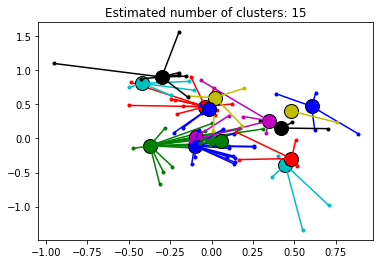

In [0]:
for i in range(len(allFiles)):
  print(f'{allFiles[i]} : {labels[i]}')

0_Dog_en.pdf : 14
0_Dog_th.pdf : 8
0_Dog_ja.pdf : 7
0_Kangaroo_en.pdf : 14
0_Kangaroo_th.pdf : 8
0_Kangaroo_ja.pdf : 7
0_Bird_en.pdf : 14
0_Bird_th.pdf : 8
0_Bird_ja.pdf : 7
0_Penguin_en.pdf : 14
0_Penguin_th.pdf : 8
0_Penguin_ja.pdf : 7
1_Hamburger_en.pdf : 0
1_Hamburger_th.pdf : 8
1_Hamburger_ja.pdf : 7
1_Steak_en.pdf : 0
1_Steak_th.pdf : 8
1_Steak_ja.pdf : 7
1_Omelette_en.pdf : 0
1_Omelette_th.pdf : 8
1_Omelette_ja.pdf : 7
1_Bacon_en.pdf : 0
1_Bacon_th.pdf : 8
1_Bacon_ja.pdf : 7
1_Sushi_en.pdf : 0
1_Sushi_th.pdf : 8
1_Sushi_ja.pdf : 7
2_Thailand_en.pdf : 2
2_Thailand_th.pdf : 8
2_Thailand_ja.pdf : 1
2_Singapore_en.pdf : 2
2_Singapore_th.pdf : 8
2_Singapore_ja.pdf : 1
2_France_en.pdf : 2
2_France_th.pdf : 8
2_France_ja.pdf : 1
2_Japan_en.pdf : 2
2_Japan_th.pdf : 8
2_Japan_ja.pdf : 1
2_Austalia_en.pdf : 2
2_Austalia_th.pdf : 8
2_Austalia_ja.pdf : 1
3_London_en.pdf : 2
3_London_th.pdf : 8
3_London_ja.pdf : 1
3_Tokyo_en.pdf : 2
3_Tokyo_th.pdf : 8
3_Tokyo_ja.pdf : 1
3_Bangkok_en.pdf : 2
